# Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import cv2

In [3]:
some_data = tfds.as_numpy(tfds.load('LFW'))['train']
photos = []
for photo in some_data:
    photos.append((cv2.resize(photo['image'], (128,128))- 127.5) / 127.5)


In [4]:
train = np.array(photos)
train.shape

(13233, 128, 128, 3)

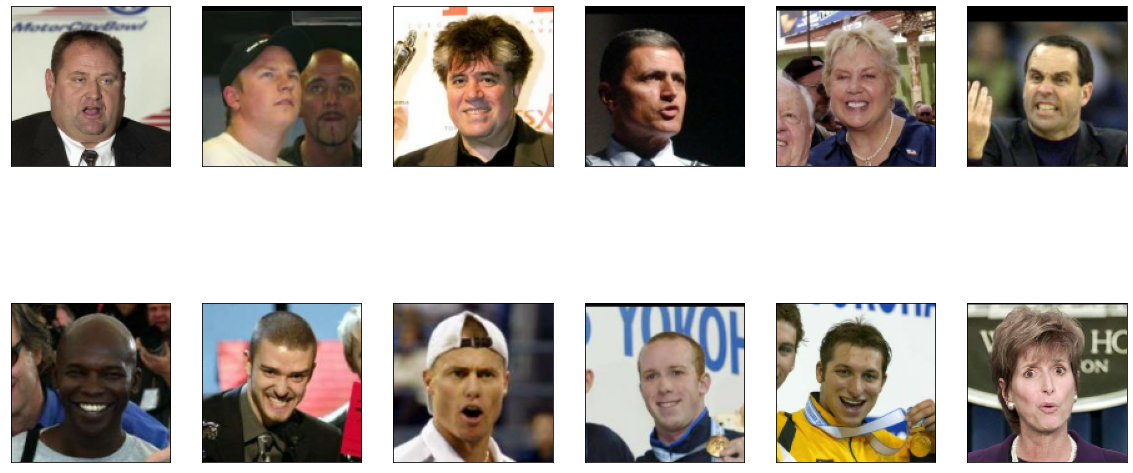

In [5]:
def plot_digits(samples):
    fig = plt.figure(figsize=(20, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(2, 6, j+1)
        ax.imshow((samples[j]+1) / 2)
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train[:12])

## Deep Convolutional GAN (DCGAN)

In [7]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*16*16*3, activation='relu',),
    tf.keras.layers.Reshape((16, 16, 128*3)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(), 
    tf.keras.layers.UpSampling2D((2, 2)),   
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'),
    tf.keras.layers.Conv2D(32, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [8]:
a = generator

In [9]:
a.compile(
    optimizer=['Adam'],
    loss=['mse']
)

In [10]:
a.build(input_shape=(32,300))
a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 98304)               29589504  
_________________________________________________________________
reshape (Reshape)            (32, 16, 16, 384)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (32, 32, 32, 384)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 32, 32, 256)         884992    
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 32, 32, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (32, 32, 32, 256)         1024      
_________________________________________________________________
re_lu (ReLU)                 (32, 32, 32, 256)         0

In [11]:
INPUT_DIM = 300
NUM_EPOCHS = 20
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0001

train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.shuffle(buffer_size=train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.9184; G Loss: 0.6668


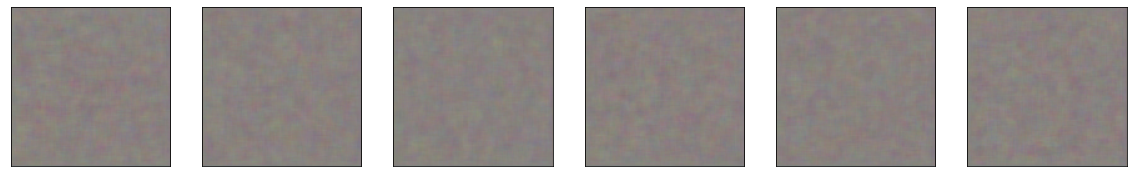

[Step 1000] D Loss: 0.8419; G Loss: 1.2085


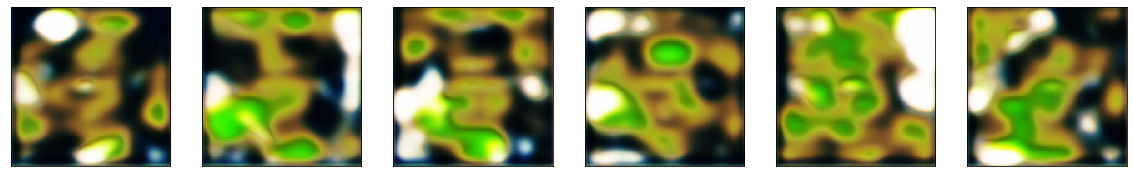

[Step 2000] D Loss: 0.5849; G Loss: 2.4025


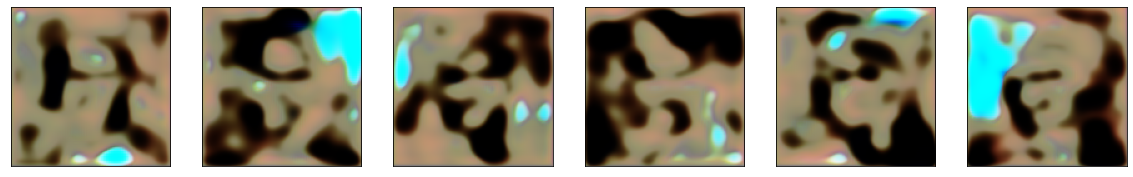

[Step 3000] D Loss: 0.3146; G Loss: 1.8620


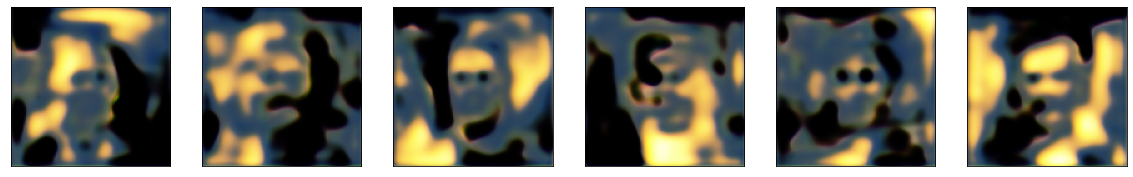

[Step 4000] D Loss: 0.1571; G Loss: 2.4194


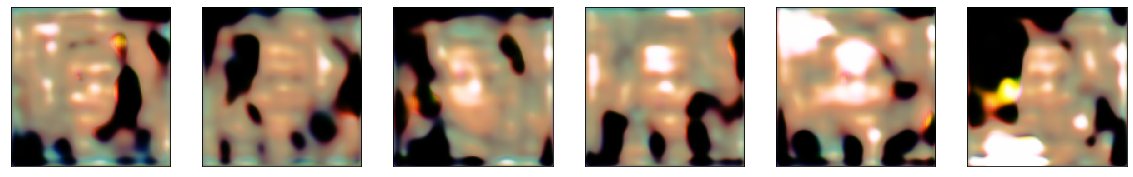

[Step 5000] D Loss: 0.3243; G Loss: 0.1182


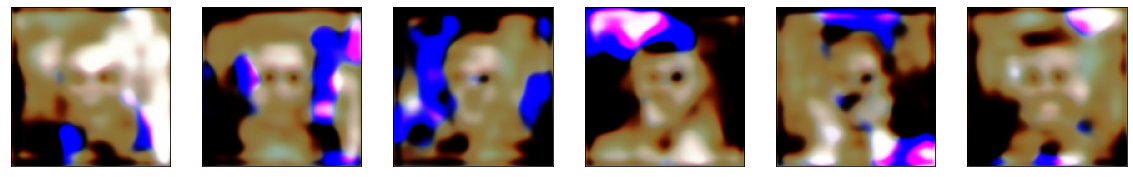

[Step 6000] D Loss: 0.1331; G Loss: 0.9846


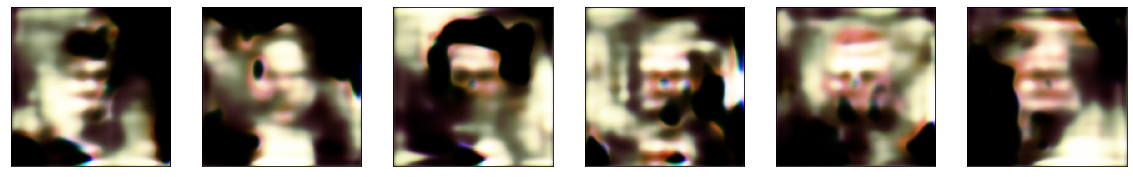

[Step 7000] D Loss: 0.3062; G Loss: 1.6797


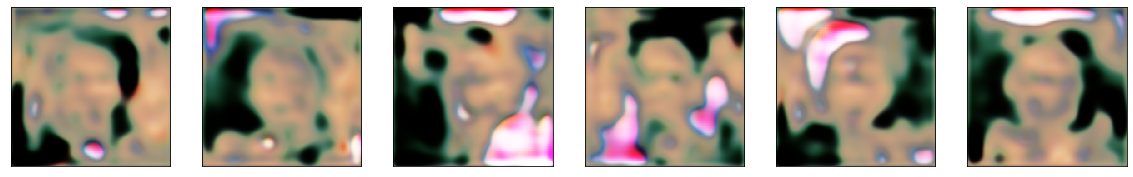

[Step 8000] D Loss: 0.4014; G Loss: 2.5051


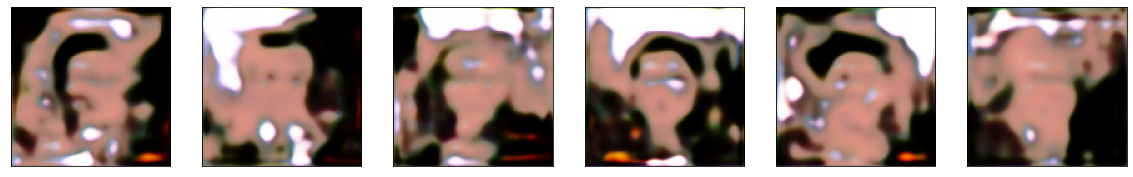

[Step 9000] D Loss: 0.6802; G Loss: 0.6272


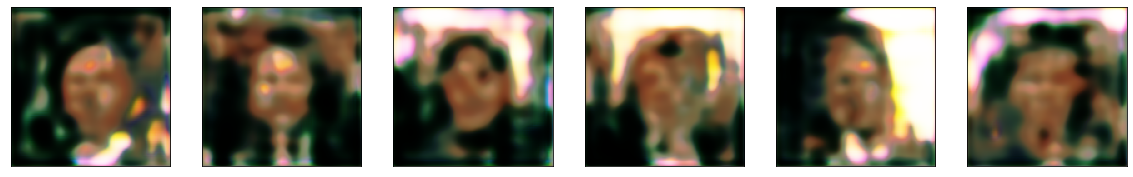

[Step 10000] D Loss: 0.9339; G Loss: 1.3688


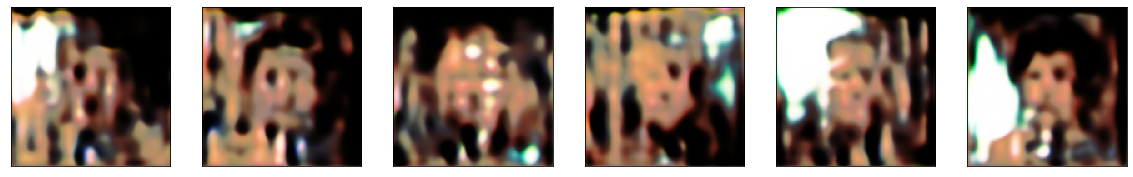

[Step 11000] D Loss: 0.3043; G Loss: 1.6411


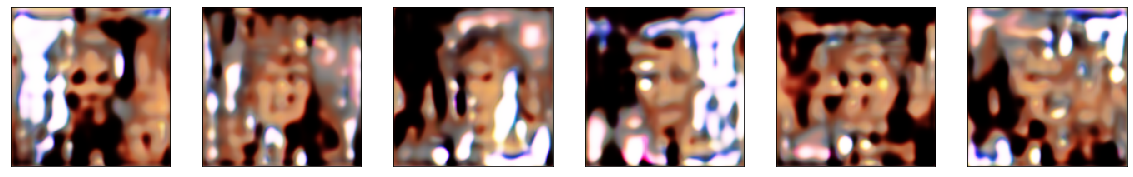

[Step 12000] D Loss: 0.4947; G Loss: 0.6265


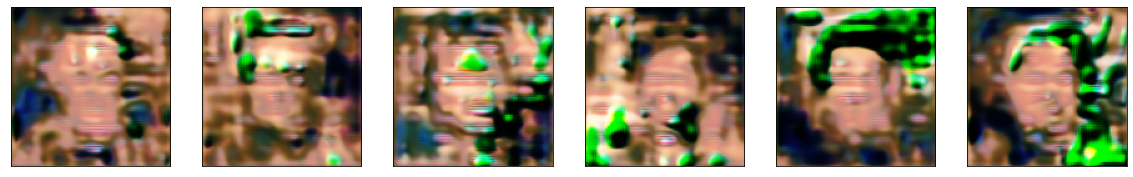

[Step 13000] D Loss: 0.3000; G Loss: 1.8065


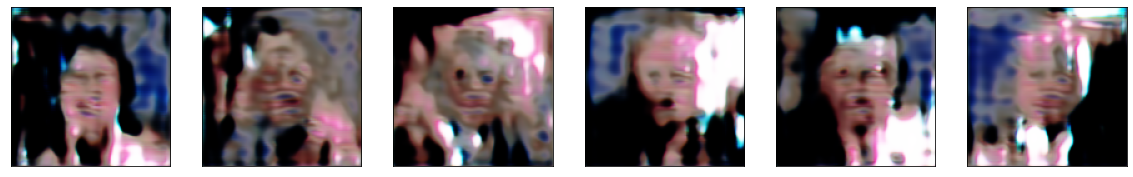

[Step 14000] D Loss: 0.2693; G Loss: 1.8954


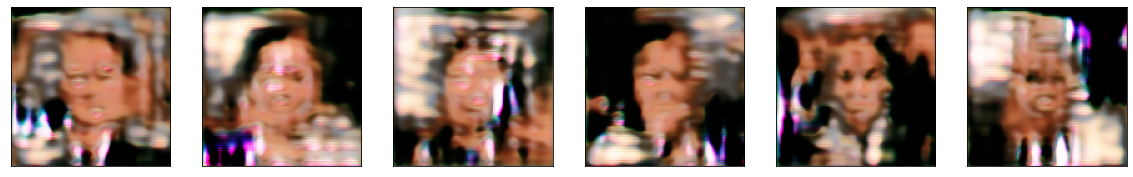

[Step 15000] D Loss: 0.1058; G Loss: 1.8048


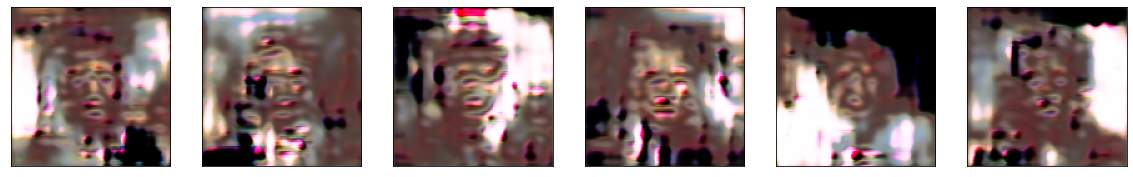

[Step 16000] D Loss: 0.1134; G Loss: 1.8074


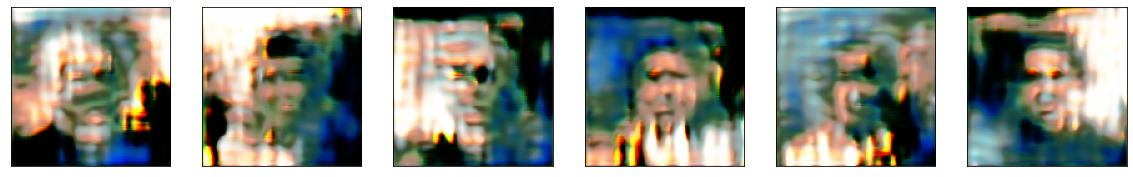

In [12]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (6, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Тестирование свёрточного генератора

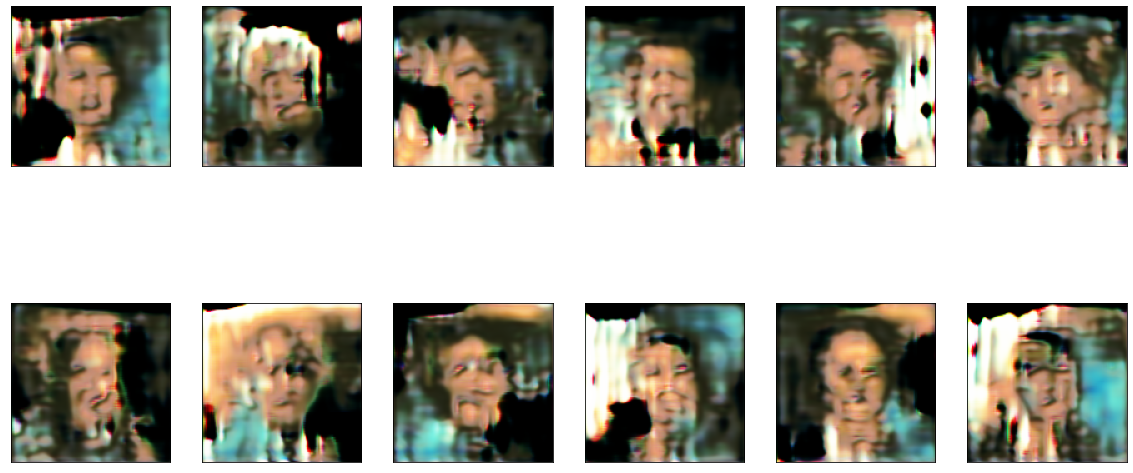

In [13]:
noise = np.random.normal(0, 1, (12, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Интерполяция в латентном пространстве

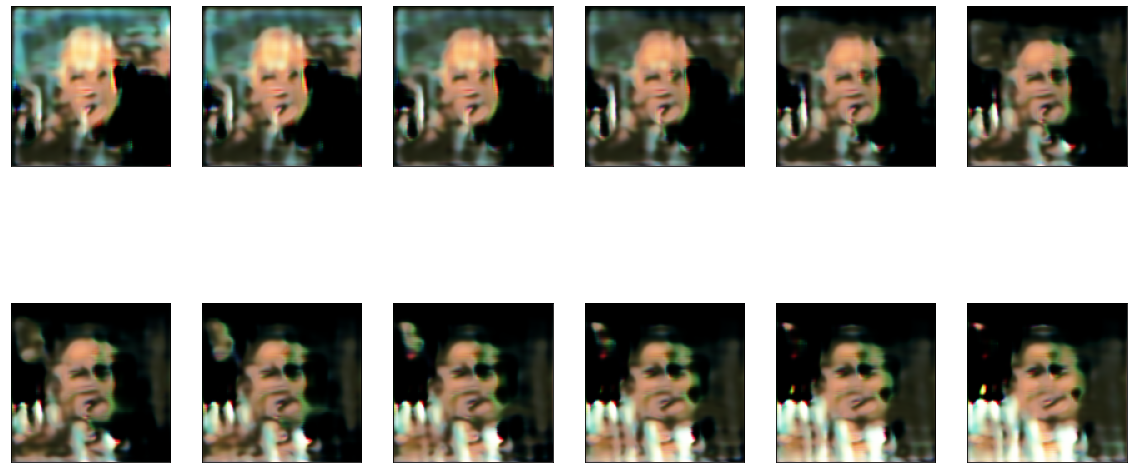

In [14]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 12)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

Люди явно пытаются получаться. Наверное зря я изменял сетрку, с первоначальным результатом получалось получше. Тут явно имеются проблемы с черным цветом. Почему-то большая часть карьинки зануляется. Так же мне показалось, что в генераторе желательно, что бы количество фильтров конволюшн сетей увеличивалось к концу, так как мы фактически рисуем. Может быть проблема еще есть в том, что у нас по несколько конволюшн слоев в геннераторе. Может, так же банально, нам нужно еще 200 эпох для нормального результата. Сказать достаточно сложно так как любой эксперимент по 2 часа.